In [81]:
import os
import re
import io
import ast
import sys
import json
import boto3 
import pymongo 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from urllib import request

sys.path.append("../")
import cabutils

## Downloading data from ec2 server 

In `settings.conf` change the `MONGODB_PORT` to 8000, and the `MONGODB_HOST` to `localhost`. Then run the ssh port into the ec2 server: 

```
ssh -i path/to/ec2-server.pem -NL 8000:localhost:27017 ubuntu@ec2-34-228-26-201.compute-1.amazonaws.com
```

Change the path to the pem key, but otherwise this should all stay the same.

In [119]:
projName = "mlve"
S3_BUCKET_NAME = "mlve-v1"
                  
download_results = { # experimentName: iterNames}
    # "gestalt_video-object-loc": ["72222_gestalt_superquadric"],
    # "gestalt_shapegen_video-object-loc": ["72222_gestalt_shapegen_video-object-loc"],
    "gestalt_object-loc": ["72122_gestalt_superquadric"],
    "gestalt_shapegen_object-loc": ["72122_gestalt_shapegen"]
}
             

In [120]:
def results_to_df():
    conn = cabutils.get_db_connection()
    all_dfs = []
    for experimentName, iterNames in download_results.items():
        print(f"Downloading results for experiment: {experimentName}")
        db = conn[projName + "_outputs"]
        col = db[experimentName]
        
        results = []
        cursor = col.find({})
        for document in cursor:
            results.append(document)

        df = pd.DataFrame(results)
        all_dfs.append(df)
        
    super_df = pd.concat(all_dfs)
    return super_df

df = results_to_df()
df.head(10)

Checking database connection...
Connection established!


,_id,image_url,probe_touching,probe_location,gt_bounding_box,mask_idx,mask_val,meta,is_duplicate,attention_check,...,time_elapsed,internal_node_id,gameid,iterationName,inputid,projName,expName,sessionID,studyID,userID
0,62d9a0f7d72a4a05052b7277,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[212, 78]","[[111, 8], [294, 167]]",0.0,40.0,{'objects': {'h1_0': {'shape_type': 'superelli...,False,False,...,318334,0.0-9.0,6703-b398a606-4fc5-4aed-861d-c192aaa7989f,72122_gestalt_superquadric,None,mlve,gestalt_object-loc,62d99facaa87cd5aa764bb25,62d99b3194b1936e3164bb18,5a01fc016e1ea9000124ddba
1,62d9a10ed72a4a05052b7278,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[200, 298]","[[126, 273], [236, 405]]",0.0,40.0,{'objects': {'h1_0': {'shape_type': 'superelli...,False,False,...,341801,0.0-10.0,6703-b398a606-4fc5-4aed-861d-c192aaa7989f,72122_gestalt_superquadric,None,mlve,gestalt_object-loc,62d99facaa87cd5aa764bb25,62d99b3194b1936e3164bb18,5a01fc016e1ea9000124ddba
2,62d9a120d72a4a05052b7279,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[247, 362]","[[107, 272], [477, 488]]",0.0,40.0,{'objects': {'h1_0': {'shape_type': 'superelli...,False,False,...,359694,0.0-11.0,6703-b398a606-4fc5-4aed-861d-c192aaa7989f,72122_gestalt_superquadric,None,mlve,gestalt_object-loc,62d99facaa87cd5aa764bb25,62d99b3194b1936e3164bb18,5a01fc016e1ea9000124ddba
3,62d9a126d72a4a05052b727a,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[216, 121]","[[155, 73], [257, 175]]",0.0,40.0,{'objects': {'h1_0': {'shape_type': 'superelli...,False,False,...,365505,0.0-12.0,6703-b398a606-4fc5-4aed-861d-c192aaa7989f,72122_gestalt_superquadric,None,mlve,gestalt_object-loc,62d99facaa87cd5aa764bb25,62d99b3194b1936e3164bb18,5a01fc016e1ea9000124ddba
4,62d9a12bd72a4a05052b727b,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,False,"[65, 75]",[],0.0,40.0,{'objects': {'h1_0': {'shape_type': 'superelli...,False,False,...,370311,0.0-13.0,6703-b398a606-4fc5-4aed-861d-c192aaa7989f,72122_gestalt_superquadric,None,mlve,gestalt_object-loc,62d99facaa87cd5aa764bb25,62d99b3194b1936e3164bb18,5a01fc016e1ea9000124ddba
5,62d9a136d72a4a05052b727c,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[190, 353]","[[127, 291], [230, 405]]",0.0,40.0,{'objects': {'h1_0': {'shape_type': 'superelli...,False,False,...,381428,0.0-14.0,6703-b398a606-4fc5-4aed-861d-c192aaa7989f,72122_gestalt_superquadric,None,mlve,gestalt_object-loc,62d99facaa87cd5aa764bb25,62d99b3194b1936e3164bb18,5a01fc016e1ea9000124ddba
6,62d9a144d72a4a05052b727d,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[148, 222]","[[110, 184], [185, 258]]",0.0,0.0,{'objects': {'h1_0': {'shape_type': 'supertoro...,False,False,...,218189,0.0-9.0,8573-d3f113c9-dc8e-418e-80af-6f580e721f29,72122_gestalt_superquadric,None,mlve,gestalt_object-loc,62d9a05f0fd9056eefe9f587,62d99b3194b1936e3164bb18,5fb82c3a8d95c82b0c5225ef
7,62d9a14ad72a4a05052b727e,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[352, 152]","[[250, 21], [442, 272]]",0.0,40.0,{'objects': {'h1_0': {'shape_type': 'superelli...,False,False,...,401579,0.0-15.0,6703-b398a606-4fc5-4aed-861d-c192aaa7989f,72122_gestalt_superquadric,None,mlve,gestalt_object-loc,62d99facaa87cd5aa764bb25,62d99b3194b1936e3164bb18,5a01fc016e1ea9000124ddba
8,62d9a14ed72a4a05052b727f,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,False,"[454, 112]",[],0.0,40.0,{'objects': {'h1_0': {'shape_type': 'superelli...,False,False,...,405966,0.0-16.0,6703-b398a606-4fc5-4aed-861d-c192aaa7989f,72122_gestalt_superquadric,None,mlve,gestalt_object-loc,62d99facaa87cd5aa764bb25,62d99b3194b1936e3164bb18,5a01fc016e1ea9000124ddba
9,62d9a152d72a4a05052b7280,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,False,"[442, 437]",[],0.0,40.0,{'objects': {'h1_0': {'shape_type': 'superelli...,False,False,...,409462,0.0-17.0,6703-b398a606-4fc5-4aed-861d-c192aaa7989f,72122_gestalt_superquadric,None,mlve,gestalt_object-loc,62d99facaa87cd5aa764bb25,62d99b3194b1936e3164bb18,5a01fc016e1ea9000124ddba


In [121]:
def download_from_s3(url, resource_type="image"):
    s3 = boto3.resource('s3', region_name="us-east-2")
    bucket = s3.Bucket(S3_BUCKET_NAME)
    item = bucket.Object(url)
    if resource_type == "image":
        file_stream = io.BytesIO()
        item.download_fileobj(file_stream)
        img = Image.open(file_stream)
        return img
    
    else:
        return item

In [122]:
def download_from_url(url):
    obj = request.urlretrieve(url)
    image = Image.open(obj[0])
    return image

In [123]:
def process_box(box):
    """
    Expects box as a tuple, of start stop points. Returns it as: [minX, minY, maxX, maxY]
    """
    minX = min(box[0][0], box[1][0])
    maxX = max(box[0][0], box[1][0])
    
    minY = min(box[0][1], box[1][1])
    maxY = max(box[0][1], box[1][1])
    
    return [int(minX), int(minY), int(maxX), int(maxY)]

def calc_mIOU(box_a, box_b, epsilon=1e-8):
    if not box_a and not box_b:
        return float("nan")
    if not box_a or not box_a:
        return 0
    
    if len(box_a) < 4:
        a = process_box(box_a)
    else:
        a = box_a
    
    if len(box_b) < 4:
        b = process_box(box_b)
    else:
        b = box_b
        
    # return np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

    # COORDINATES OF THE INTERSECTION BOX
    
    xA = max(a[0], b[0])
    yA = max(a[1], b[1])
    xB = min(a[2], b[2])
    yB = min(a[3], b[3])
    
    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both AABBs
    bb1_area = (a[2] - a[0] + 1) * (a[3] - a[1] + 1)
    bb2_area = (b[2] - b[0] + 1) * (b[3] - b[1] + 1)
    if intersection_area == (bb1_area + bb2_area):
        return float('nan')
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou


In [124]:
# df.to_csv(EXPERIMENT_NAME + "-results.csv")

In [125]:
df["correct"].mean()

0.8656706141558799

In [126]:
df[df["expName"] == "gestalt_shapegen_object-loc"]["correct"].mean()

0.8917972911276822

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14684 entries, 0 to 6651
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _id                   14684 non-null  object 
 1   image_url             14524 non-null  object 
 2   probe_touching        14524 non-null  object 
 3   probe_location        14524 non-null  object 
 4   gt_bounding_box       14524 non-null  object 
 5   mask_idx              14524 non-null  float64
 6   mask_val              14524 non-null  float64
 7   meta                  14524 non-null  object 
 8   is_duplicate          14524 non-null  object 
 9   attention_check       14524 non-null  object 
 10  batch_num             14524 non-null  float64
 11  rt                    14684 non-null  int64  
 12  stimulus              14524 non-null  object 
 13  response              14684 non-null  object 
 14  correct               14524 non-null  object 
 15  subject_bounding_box

In [128]:
sns.set_context("poster")

In [129]:
df["Trial Type"] = df["expName"].apply(lambda x: "Static" if "video" not in x else "Dynamic")

In [130]:
def trial_description(x):
    if x == "gestalt_object-loc":
        return "Static Simple Shapes"
    elif x == "gestalt_video-object-loc":
        return "Dynamic Simple Shapes"
    elif x == "gestalt_shapegen_video-object-loc":
        return "Dynamic Complex Shapes"
    else:
        return "Static Complex Shapes"
    
df["Trial Description"] = df["expName"].apply(lambda x: trial_description(x))

# Generate cleaned version

In [131]:
df.head()

,_id,image_url,probe_touching,probe_location,gt_bounding_box,mask_idx,mask_val,meta,is_duplicate,attention_check,...,gameid,iterationName,inputid,projName,expName,sessionID,studyID,userID,Trial Type,Trial Description
0,62d9a0f7d72a4a05052b7277,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[212, 78]","[[111, 8], [294, 167]]",0.0,40.0,{'objects': {'h1_0': {'shape_type': 'superelli...,False,False,...,6703-b398a606-4fc5-4aed-861d-c192aaa7989f,72122_gestalt_superquadric,None,mlve,gestalt_object-loc,62d99facaa87cd5aa764bb25,62d99b3194b1936e3164bb18,5a01fc016e1ea9000124ddba,Static,Static Simple Shapes
1,62d9a10ed72a4a05052b7278,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[200, 298]","[[126, 273], [236, 405]]",0.0,40.0,{'objects': {'h1_0': {'shape_type': 'superelli...,False,False,...,6703-b398a606-4fc5-4aed-861d-c192aaa7989f,72122_gestalt_superquadric,None,mlve,gestalt_object-loc,62d99facaa87cd5aa764bb25,62d99b3194b1936e3164bb18,5a01fc016e1ea9000124ddba,Static,Static Simple Shapes
2,62d9a120d72a4a05052b7279,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[247, 362]","[[107, 272], [477, 488]]",0.0,40.0,{'objects': {'h1_0': {'shape_type': 'superelli...,False,False,...,6703-b398a606-4fc5-4aed-861d-c192aaa7989f,72122_gestalt_superquadric,None,mlve,gestalt_object-loc,62d99facaa87cd5aa764bb25,62d99b3194b1936e3164bb18,5a01fc016e1ea9000124ddba,Static,Static Simple Shapes
3,62d9a126d72a4a05052b727a,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,True,"[216, 121]","[[155, 73], [257, 175]]",0.0,40.0,{'objects': {'h1_0': {'shape_type': 'superelli...,False,False,...,6703-b398a606-4fc5-4aed-861d-c192aaa7989f,72122_gestalt_superquadric,None,mlve,gestalt_object-loc,62d99facaa87cd5aa764bb25,62d99b3194b1936e3164bb18,5a01fc016e1ea9000124ddba,Static,Static Simple Shapes
4,62d9a12bd72a4a05052b727b,https://mlve-v1.s3.us-east-2.amazonaws.com/ges...,False,"[65, 75]",[],0.0,40.0,{'objects': {'h1_0': {'shape_type': 'superelli...,False,False,...,6703-b398a606-4fc5-4aed-861d-c192aaa7989f,72122_gestalt_superquadric,None,mlve,gestalt_object-loc,62d99facaa87cd5aa764bb25,62d99b3194b1936e3164bb18,5a01fc016e1ea9000124ddba,Static,Static Simple Shapes


## Let's quickly look at the comments

In [133]:
all_comments = df[df["trial_type"] == "survey-text"]["response"]
comments = []
for response in all_comments:
    comm = response["Q0"]
    if len(comm) > 0:
        print(comm)
        comments.append(comm)
# print(comments)

quite fun 
Enjoyable study 
Very difficult
i accidentally pressed 'no' on one question instead of 'yes', sorry!
it was cool
While i was giving my 100% for the testing, i still feel like i missed some or saw shapes that wasnt there
No
I enjoyed  the Japanese Macaque in the middle :)
I wasn't sure whether there was a bigger shape that narrowed at certain points, so I may have highlighted what I thought was the bigger shape, rather than the smaller section. I hope it's useful though. Thanks
I had fun doing that and would like to do more.
no
-
no
My only comment is that if you try to drag your rectangle to the edge of the image, it often messes up your ability to finalise that selection, making you have to redraw - This was not a massive problem to deal with at all, though.
Really enjoyed taking part, would be more than willing to do similar surveys like this in the future. Many thanks.
That was fun!
The more white/larger the dots, the more difficult it is to discern. Though, the eye break

In [134]:
df.drop(df[df["trial_type"] != "object-localization-task"].index, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14392 entries, 0 to 6650
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _id                   14392 non-null  object 
 1   image_url             14392 non-null  object 
 2   probe_touching        14392 non-null  object 
 3   probe_location        14392 non-null  object 
 4   gt_bounding_box       14392 non-null  object 
 5   mask_idx              14392 non-null  float64
 6   mask_val              14392 non-null  float64
 7   meta                  14392 non-null  object 
 8   is_duplicate          14392 non-null  object 
 9   attention_check       14392 non-null  object 
 10  batch_num             14392 non-null  float64
 11  rt                    14392 non-null  int64  
 12  stimulus              14392 non-null  object 
 13  response              14392 non-null  object 
 14  correct               14392 non-null  object 
 15  subject_bounding_box

In [135]:
participants = df.groupby("userID")
participants_failed = []j
i = 0 
n_trials = 81
score_threshold = 0.5


for index, user_results in participants:
    i += 1
    trials_finished = len(user_results)
    if trials_finished < n_trials - 10:
        print("USER ID: " + user_results["userID"].iloc[0] + " only completed: " + str(trials_finished) + " trials")
        participants_failed.append(user_results["userID"].iloc[0])
        continue
    
    correct_score = user_results["correct"].mean()
    if correct_score < score_threshold:
        print("USER ID: " + user_results["userID"].iloc[0] + " scored " + str(correct_score))
        participants_failed.append(user_results["userID"].iloc[0])
        continue
        
#     attention_checks = user_results[user_results["stimulus"].str.contains("ground_truth")]
#     if attention_checks["correct"].sum() < 2:
#         print("USER ID: " + user_results["userID"].iloc[0] + " faled too many attention checks")
#         participants_failed.append(user_results["userID"].iloc[0])

# participants_failed.append("60cb62a4e099dcbffe591021")
# participants_failed.append("5ec3d06016290204b072564d")
print(participants_failed)

SyntaxError: invalid syntax (1644960164.py, line 2)

In [136]:
remove_failure_cases = False

In [137]:
if remove_failure_cases:
    failed_participants = df["userID"].apply(lambda x: x in participants_failed)
    df = df[~failed_participants]
    attention_checks = df["stimulus"].apply(lambda x: "ground_truth" in x)
    df = df[~attention_checks]

# Create directory for figures

In [138]:
if not os.path.exists(f"figures/{experimentName}"):
    os.makedirs(f"figures/{experimentName}")

NameError: name 'experimentName' is not defined

## Create texture_name column

In [139]:
ious = []
for index, row in df.iterrows():
    gtbb = row["gt_bounding_box"]
    if type(gtbb) == str:
        gtbb = str_to_list(gtbb)
    ubb = row["subject_bounding_box"]
    if type(ubb) == str:
        ubb = str_to_list(ubb)

    if (not ubb and not gtbb) or (ubb and not gtbb):
        ious.append(float("nan"))
        continue 

    elif (not ubb and gtbb):
        ious.append(0)
        continue

    else:
        iou = calc_mIOU(gtbb, ubb)
        ious.append(iou)

df["miou"] = ious

In [140]:
user_means = df.groupby("userID")["miou"].mean()
low_miou = user_means[user_means < 0.2]
low_miou_user_ids = [x for x in low_miou.keys()]
all_participants_failed = low_miou_user_ids

In [141]:
participants_failed

NameError: name 'participants_failed' is not defined

In [142]:
sns.set_context("poster")
sns.set(font_scale=3.5)
sns.set_style("white")

In [169]:
colors = np.array(COLORS) * 255
colors

array([[  0.   , 113.985, 188.955],
       [216.75 ,  82.875,  24.99 ],
       [236.895, 176.97 ,  31.875],
       [125.97 ,  46.92 , 141.78 ]])

In [143]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125], [0.494, 0.184, 0.556]]
palette = {"Dynamic Simple Shapes": [0.000, 0.447, 0.741],
        "Dynamic Complex Shapes": [0.850, 0.325, 0.098],
        "Static Simple Shapes": [0.929, 0.694, 0.125],
        "Static Complex Shapes": [0.494, 0.184, 0.556]}

In [144]:
hue_order = ["Static Simple Shapes", "Static Complex Shapes"]

In [ ]:
figure = plt.figure(figsize=(12,8))
sns.

<Figure size 864x576 with 0 Axes>

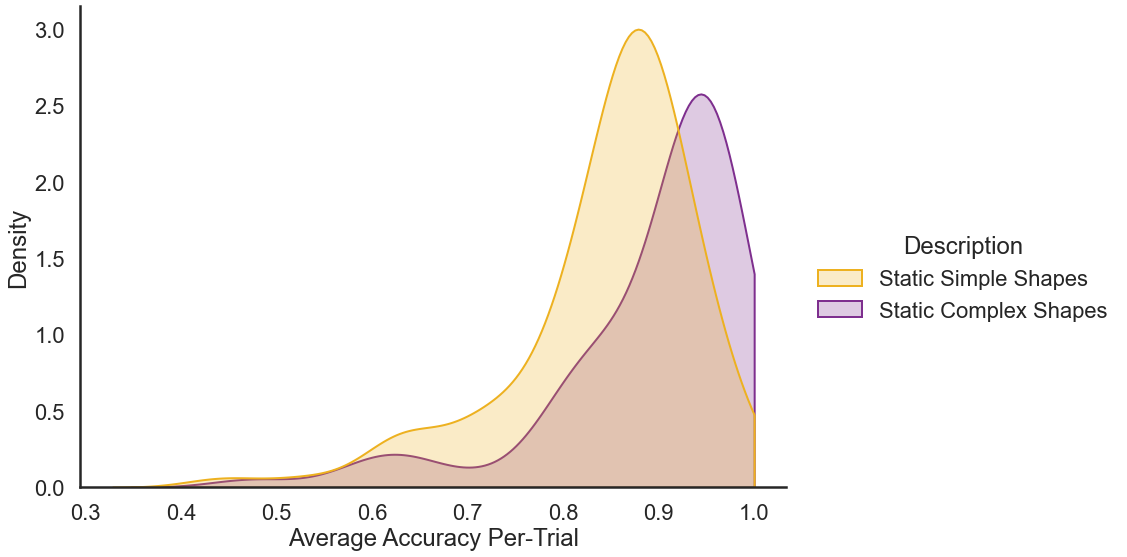

In [216]:
accuracies = []
textures = []
targets = ["stimulus", "Trial Description"]
challenging_stimuli = []
for (userID, description), trials in df.groupby(targets): 
    accuracy = trials["correct"].mean()
    accuracies.append({"Accuracy": accuracy, "Description": description})
#     accuracies.append(accuracy)
    

accuracy_df = pd.DataFrame(accuracies)            
figure = plt.figure(figsize=(12,8))
sns.displot(x="Accuracy", hue="Description",
            palette=palette,
            data=accuracy_df, 
            kind="kde", 
            height=8.27, aspect=11.7/8.27, 
            fill=True, 
            clip=[0, 1], 
            hue_order=hue_order)

plt.xlabel("Average Accuracy Per-Trial")
plt.savefig(f"figures/cogsci2022_trial-accuracy_bbox_gestalt_static.pdf", format="pdf")
plt.show()


<Figure size 864x576 with 0 Axes>

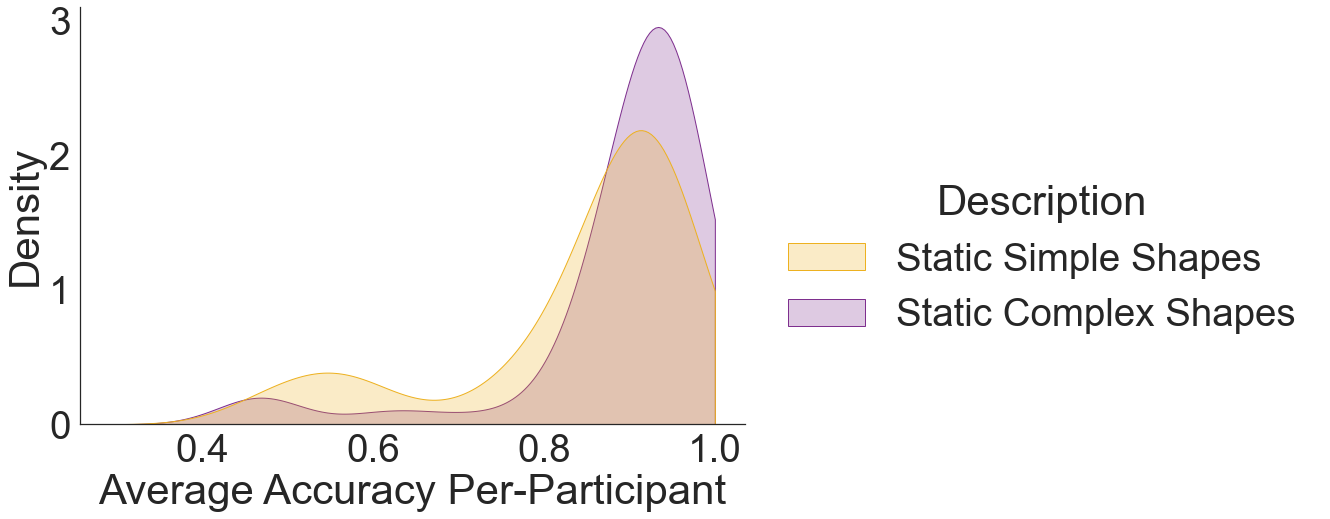

In [146]:
accuracies = []
textures = []
targets = ["userID", "Trial Description"]
challenging_stimuli = []
for (userID, description), trials in df.groupby(targets): 
    accuracy = trials["correct"].mean()
    accuracies.append({"Accuracy": accuracy, "Description": description})
#     accuracies.append(accuracy)
    

accuracy_df = pd.DataFrame(accuracies)            
figure = plt.figure(figsize=(12,8))
sns.displot(x="Accuracy", hue="Description",
            palette=palette,
            data=accuracy_df, 
            kind="kde", 
            height=8.27, aspect=11.7/8.27, 
            fill=True, 
            clip=[0, 1], 
            hue_order=hue_order)

plt.xlabel("Average Accuracy Per-Participant")
plt.savefig(f"figures/cogsci2022_participant-accuracy_bbox_gestalt_static.pdf", format="pdf")

plt.show()
# plt.savefig(f"figures/{experimentName}/mean_accuracy_hist_per_{target}.png")

<Figure size 864x576 with 0 Axes>

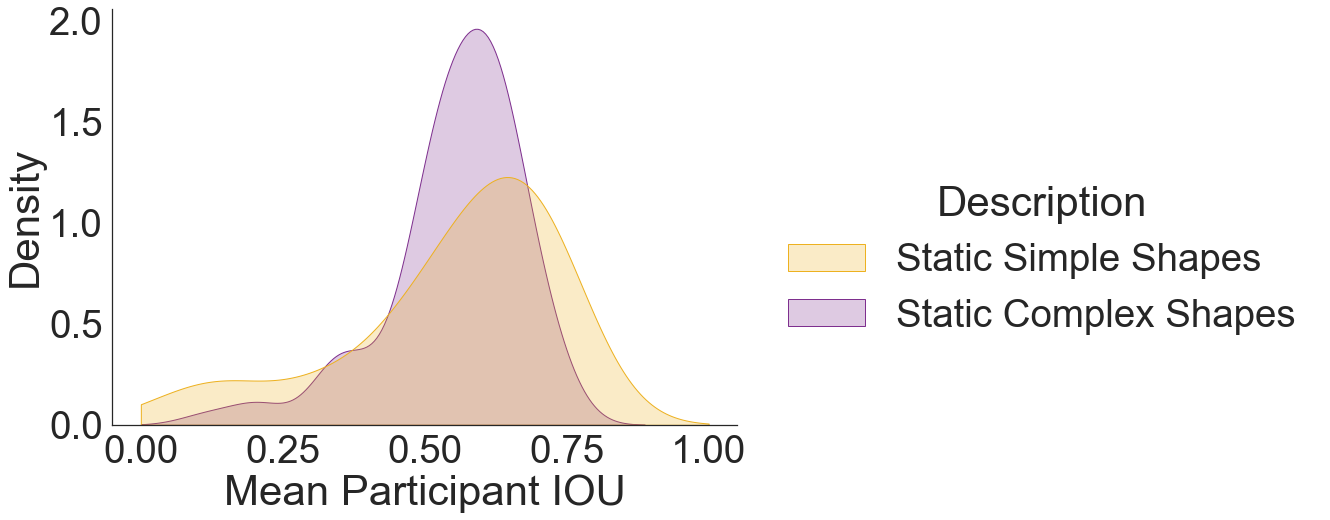

In [147]:
accuracies = []
textures = []
targets = ["userID", "Trial Description"]
challenging_stimuli = []
for (userID, description), trials in df.groupby(targets): 
    accuracy = trials["miou"].mean()
    accuracies.append({"IOU": accuracy, "Description": description})
#     accuracies.append(accuracy)
    

iou_df = pd.DataFrame(accuracies)            
figure = plt.figure(figsize=(12,8))
sns.displot(x="IOU", hue="Description",
            palette=palette,
            data=iou_df, 
            kind="kde", 
            height=8.27, aspect=11.7/8.27, 
            fill=True, 
            clip=[0, 1], 
            hue_order=hue_order)

plt.xlabel("Mean Participant IOU")
plt.savefig(f"figures/cogsci2022_participant-iou_bbox_gestalt_static.pdf", format="pdf")

# plt.savefig(f"figures/{experimentName}/mean_accuracy_hist_per_{target}.png")

<Figure size 864x576 with 0 Axes>

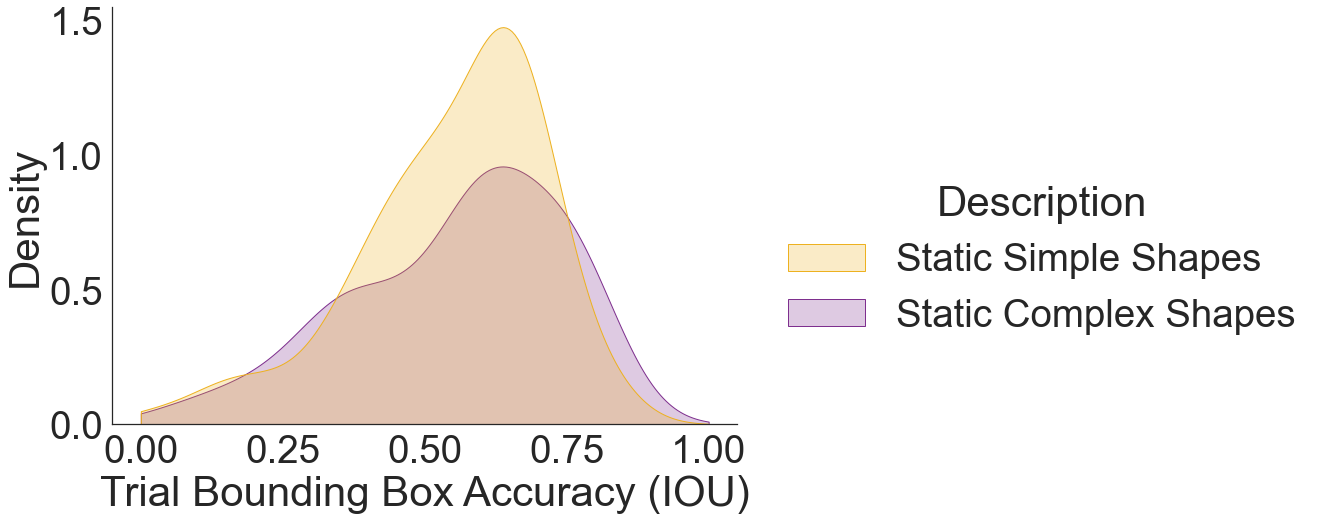

In [149]:
accuracies = []
textures = []
targets = ["stimulus", "Trial Description"]
challenging_stimuli = []
for (userID, description), trials in df.groupby(targets): 
    accuracy = trials["miou"].mean()
    accuracies.append({"IOU": accuracy, "Description": description})
#     accuracies.append(accuracy)
    

iou_df = pd.DataFrame(accuracies)            
figure = plt.figure(figsize=(12,8))
sns.displot(x="IOU", hue="Description",
            palette=palette,
            data=iou_df, 
            kind="kde", 
            height=8.27, aspect=11.7/8.27, 
            fill=True, 
            clip=[0, 1], 
            hue_order=hue_order)

plt.xlabel("Trial Bounding Box Accuracy (IOU)")
plt.savefig(f"figures/cogsci2022_trial-iou_bbox_gestalt_static.pdf", format="pdf")

# plt.savefig(f"figures/{experimentName}/mean_accuracy_hist_per_{target}.png")

Text(0.5, 1.0, 'Trial Mean Accuracy')

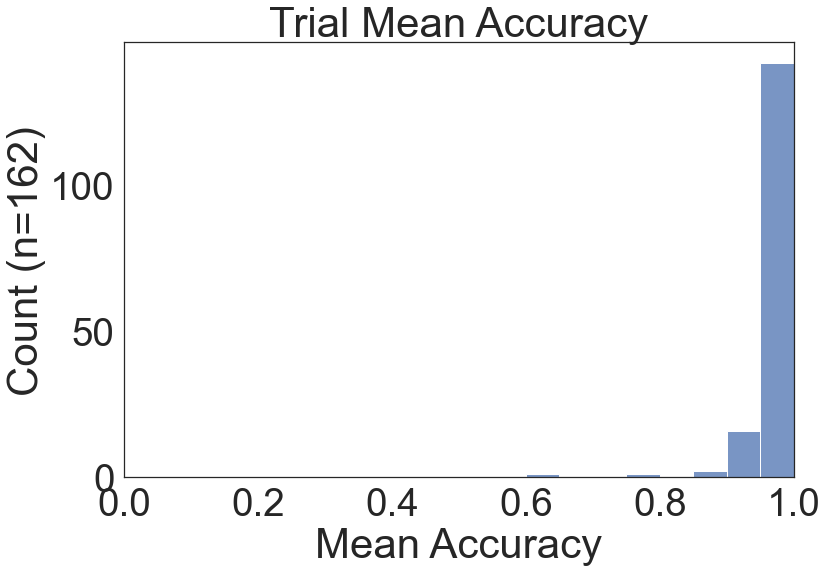

In [79]:
accuracies = []
textures = []
target = "stimulus"
challenging_stimuli = []
for index, trials in df.groupby(target): 
    accuracy = trials["correct"].mean()
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    
    
figure = plt.figure(figsize=(12,8))
sns.histplot(x=accuracies, binwidth=.05)
plt.xlim(0, 1)
plt.xlabel("Mean Accuracy")
plt.ylabel(f"Count (n={len(accuracies)})")
plt.title(f"Trial Mean Accuracy")
# plt.savefig(f"figures/{experimentName}/mean_accuracy_hist_per_{target}.png")

#  mIOU


Text(0.5, 1.0, 'mIOU per-participant')

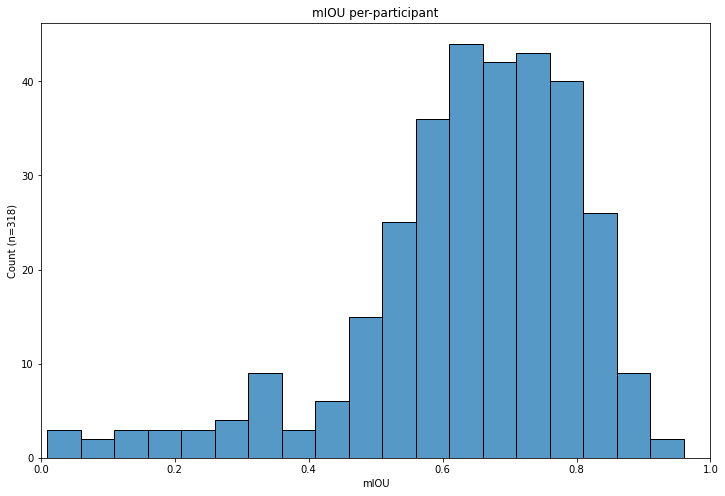

In [166]:
accuracies = []
textures = []
target = "userID"
challenging_stimuli = []
for index, trials in df.groupby(target): 
    accuracy = trials["miou"].mean()
    
    if accuracy < 0.5:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    
    
figure = plt.figure(figsize=(12,8))
sns.histplot(x=accuracies, binwidth=.05)
plt.xlim(0, 1)
plt.xlabel("mIOU")
plt.ylabel(f"Count (n={len(accuracies)})")
plt.title(f"mIOU per-participant")
# plt.savefig(f"figures/{experimentName}/mean_miou_hist_per_{target}.png")

Text(0.5, 1.0, 'mIOU per-stimuli')

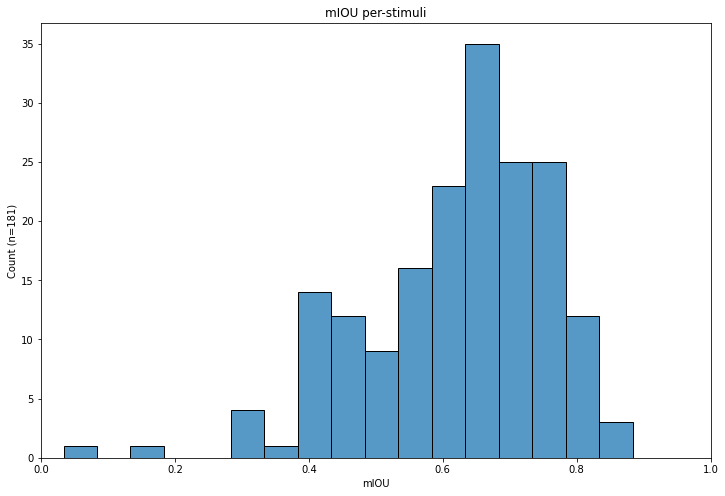

In [167]:
accuracies = []
textures = []
target = "stimulus"
challenging_stimuli = []
for index, trials in df.groupby(target): 
    accuracy = trials["miou"].mean()
    
    if accuracy < 0.25:
        challenging_stimuli.append((accuracy, trials["stimulus"].iloc[0]))
    accuracies.append(accuracy)
    
    
figure = plt.figure(figsize=(12,8))
sns.histplot(x=accuracies, binwidth=.05)
plt.xlim(0, 1)
plt.xlabel("mIOU")
plt.ylabel(f"Count (n={len(accuracies)})")
plt.title(f"mIOU per-stimuli")
# plt.savefig(f"figures/{experimentName}/mean_miou_hist_per_{target}.png")

In [168]:
challenging_stimuli

[(0.03372999619521369,
  'https://mlve-v1.s3.us-east-2.amazonaws.com/gestalt/images/image_019.png'),
 (0.17516143012284444,
  'https://mlve-v1.s3.us-east-2.amazonaws.com/gestalt/images/image_086.png')]

In [150]:
def add_box(box, ax, alpha=0.8, color="red", linewidth=5):
    if len(box) != 4:
        box = process_box(box)
    width = box[2] - box[0]
    height = box[3] - box[1]
    if not color or color == "random":
        import random
        color = "#%06x" % random.randint(0, 0xFFFFFF)
        
    rect = patches.Rectangle((box[0], box[1]), width, height, linewidth=linewidth, edgecolor=color, 
                             alpha=alpha, facecolor='none')
    ax.add_patch(rect)
    return ax

def plot_trial(trial):
    fig, ax = plt.subplots(figsize=(16,12))
    print(trial["userID"])
    
    gt_bb = trial["gt_bounding_box"]
    s_bb = trial["subject_bounding_box"]
    
    print(gt_bb, s_bb)
    if gt_bb:
        add_box(gt_bb, ax, color="blue", alpha=0.75)
        
    if s_bb:
        add_box(s_bb, ax, color="red", alpha=0.75)
        
    url = trial["stimulus"]
    image = download_from_url(url)

    probe_location = trial["probe_location"]
    
    ax.imshow(image, cmap="gray")

    # Add probes
    probe = patches.Circle(probe_location, radius=12, color="#69597f", alpha=0.8)
    ax.add_patch(probe)
    probe = patches.Circle(probe_location, radius=4, color="#ff0601", alpha=1)
    ax.add_patch(probe)

    return fig

0.86767931384424
5a01fc016e1ea9000124ddba
[[111, 8], [294, 167]] [[124.515625, 7], [300.515625, 162]]


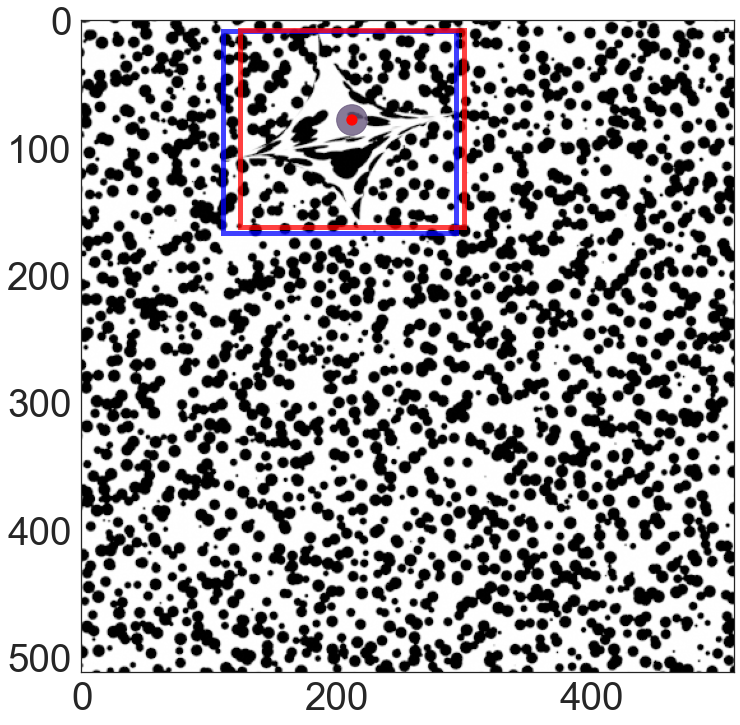

0.6405883884405102
5a01fc016e1ea9000124ddba
[[126, 273], [236, 405]] [[123.5, 269], [260.5, 435]]


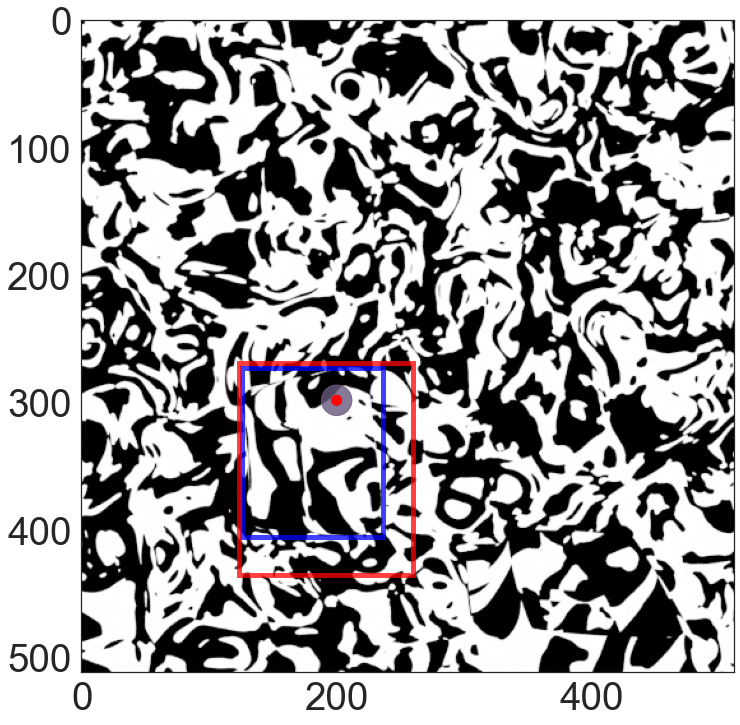

0.7686834389811457
5a01fc016e1ea9000124ddba
[[107, 272], [477, 488]] [[156.515625, 283], [492.515625, 496]]


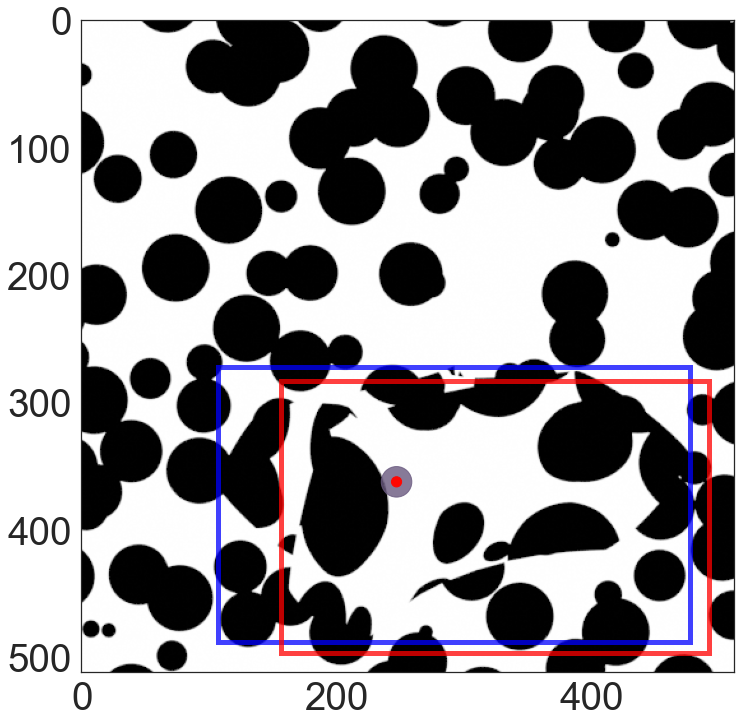

IndexError: list index out of range

In [151]:
for index, trial in df.iterrows():
    miou = calc_mIOU(trial["gt_bounding_box"], trial["subject_bounding_box"])
    print(miou)
    fig=plot_trial(trial)
    plt.show()
    plt.close()

In [ ]:
avg_bboxes = False
run_plots = True

save_path = "figures/cogsci2022_res_"
# if not os.path.exists(save_path):
#     os.mkdir(save_path)
    
if run_plots:
    for index, trials in df.groupby("stimulus"):
        
        url = index
        if "shapegen" not in url:
            continue
            
        image = download_from_url(url)

        # Add probes
        probe_locations = np.unique(trials["probe_location"])
        probe_touching = trials.iloc[0]["probe_touching"]

        if not probe_touching:
            continue 

        fig, ax = plt.subplots(1,1, figsize=(16, 12))
        image = download_from_url(url)

        ax.imshow(image, cmap="gray")
        for probe_location in probe_locations:
            probe = patches.Circle(probe_location, radius=12, color="#69597f", alpha=0.8)
            ax.add_patch(probe)

            probe = patches.Circle(probe_location, radius=4, color="#ff0601", alpha=1)
            ax.add_patch(probe)
        
        gt_bbs = np.unique(trials["gt_bounding_box"])
        for i, gt_bb in enumerate(gt_bbs):
            if not gt_bb:
                continue
            ax = add_box(gt_bb, ax, color=COLORS[i], linewidth=10, alpha=1)

        avg_bb = []
        count = 0
        for i, trial in trials.iterrows():
            s_bb = trial["subject_bounding_box"]
            if s_bb:
                if avg_bboxes:
                    box = np.array(process_box(s_bb))
                    count += 1
                    if not len(avg_bb):
                        avg_bb.append(box)
                    else:
                        avg_bb.append(box)
                else: 
                    add_box(s_bb, ax, alpha=0.5, linewidth=2.5, color="random")

        if avg_bboxes:
            avg_bb = np.array(avg_bb).mean(axis=0)
            add_box(avg_bb, ax, alpha=0.9, linewidth=5, color="blue")
            miou = calc_mIOU(avg_bb, gt_bb)
            print(miou)
        

        trial_name = url.split(".com")[1][1:].replace("/", "-")
        trial_name = trial_name.replace("-images", "")
        
        # plt.title(trial_name)
        plt.axis('off')
        plt.savefig(os.path.join(save_path + trial_name + ".pdf"), format="pdf", bbox_inches="tight")
        plt.show()
        plt.close()

In [197]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))


In [199]:
sns.set_context("poster")

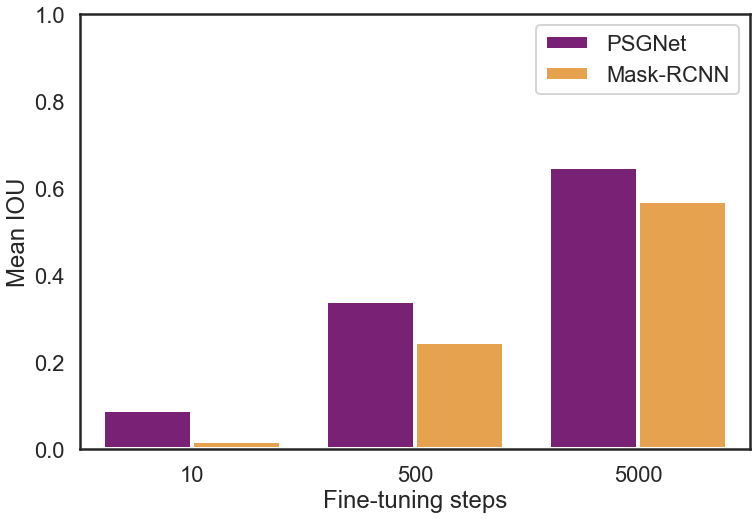

In [263]:
psg_data = [0.09, 0.34, 0.65] # 10, 500, 5000
mask_rcnn = [0.02, 0.246, 0.57]

xs = [10, 500, 5000]

palette = {"PSGNet": "#871282", "Mask-RCNN": "#ffa535"}
results_df = pd.DataFrame({"Mean IOU": [0.09, 0.34, 0.65, 0.02, 0.246, 0.57], 
                           "Model": ["PSGNet", "PSGNet", "PSGNet", "Mask-RCNN","Mask-RCNN","Mask-RCNN"],
                           "Fine Tuning Steps": [10, 500, 5000, 10, 500, 5000]})

fig, ax = plt.subplots(1, 1 , figsize=(12, 8))

sns.barplot(x="Fine Tuning Steps", y="Mean IOU", hue="Model", data=results_df,
            palette=palette, linewidth=4, ax=ax)
# sns.barplot(x=xs, y=mask_rcnn, label="Mask-RCNN", color="#AA00FF", dodge=True, linewidth=4, ax=ax)

# sns.scatterplot(x=xs, y=psg_data, label="PSGNet", color="#FF00AA", s=50, ax=ax)
# sns.scatterplot(x=xs, y=mask_rcnn, label="Mask-RCNN", color="#AA00FF", s=50, ax=ax)

plt.ylim(0, 1)
# ax.set_xscale("log")
plt.ylabel("Mean IOU")
plt.xlabel("Fine-tuning steps")

legend_without_duplicate_labels(ax)
plt.savefig("figures/cogsci2022_modelcompare_A.pdf", format="pdf")